In [1]:
import numpy as np
import csv
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
import pylab
import scipy
import scipy.stats
import math
import pandas as pd

In [2]:
class MedianPolish:
    """Fits an additive model using Tukey's median polish algorithm"""

    #note that the self argument is default that allows reference to an instance of the
    #class that has been defined by the user
    #no argument is actally specified to be passed to the self argument by the user;
    #the first user specified argument
    #goes into the first argument listed after self in the code of the class
    def __init__(self, array): 
        """Get numeric data from numpy ndarray to self.tbl, keep the original copy in tbl_org"""
        #checks if the argument called array is actually a numerical array of the
        #object type np.ndarray by using the comparison function isinstance
        if isinstance(array, np.ndarray):
            self.tbl_org = array
            #tbl_org will allow you to compare the final polished matrix with row and column
            #effects removed to the original unpolished matrix
            self.tbl = self.tbl_org.copy()
        else:
            raise TypeError('Expected the argument to be a numpy.ndarray.')

    @staticmethod
    def csv_to_ndarray(fname): 
        """ Utility method for loading ndarray from .csv file""" 
        try:
            #generates an array-like object of type np.ndarray
            #from a comma separated values file
            return np.genfromtxt(fname, delimiter=",")	
        except Exception, e:
            print "Error loading file %s:" % fname
            raise

    def median_polish(self, max_iterations, method):
        """
            Implements Tukey's median polish alghoritm for additive models
            method - default is median, alternative is mean. That would give us result equal ANOVA.
        """
        
        grand_effect = 0
        median_row_effects = 0
        median_col_effects = 0
        #defines a vector that stores the row_effects during each iteration;
        #the vector is initialized with zeros and length equal to the number of rows
        #as determined by the function shape[0]
        row_effects = np.zeros(shape=self.tbl.shape[0])
        col_effects = np.zeros(shape=self.tbl.shape[1])

        for i in range(max_iterations):
            if method == 'median':
                #note that np.median's second arg specifies along which axis to perform
                #the median calculation, with axis = 1 being rows, and axis = 0 being columns
                row_medians = np.median(self.tbl, 1)
                #the next line keeps a running total of the row effects that have been
                #subtracted out during the iterative polishing procedure
                row_effects += row_medians
                median_row_effects = np.median(row_effects)
            elif method == 'average':
                row_medians = np.average(self.tbl, 1) 
                row_effects += row_medians
                median_row_effects = np.average(row_effects)
            
            #not sure what the grand_effect variable is keeping track of; it is
            #returned but never used in later calculations
            grand_effect += median_row_effects
            
            #the following line I have commented out, don't know why it is needed
            #row_effects -= median_row_effects
            
            #the following line reshapes the the row_medians array into a column
            #this reshaping is necessary because each element in row_medians
            #is the median from each row, which needs to be subtracted from each row
            #by reshaping into a column, can simply subtract this column from each
            #column of the data matrix, self.tbl
            #the np.newaxis function adds a new dimension, such that now the array
            #is a matrix with n number of rows and 1 column; hence the array is now a
            #column vector.
            self.tbl -= row_medians[:, np.newaxis]

            if method == 'median':
                col_medians = np.median(self.tbl, 0) 
                col_effects += col_medians
                median_col_effects = np.median(col_effects)
            elif method == 'average':
                col_medians = np.average(self.tbl, 0) 
                col_effects += col_medians
                median_col_effects = np.average(col_effects)

            #note that by default, arrays such as col_medians are formulated as a row vector
            #for use in numerical calculations
            self.tbl -= col_medians
            
            #the following line I have commented out, don't know why it is needed
            #col_effects -= col_medians
            
            grand_effect += median_col_effects

        return grand_effect, col_effects, row_effects , self.tbl, self.tbl_org

In [3]:
#sorts data along a given column; can do the reverse (largest to smallest)
def sort_candidates(candidates_list, index_to_rank, flag_reverse_rank):
    if len(candidates_list) == 0:
        return candidates_list
    else:
        data_to_rank = candidates_list[:, index_to_rank]

        if flag_reverse_rank == 1:
            data_to_rank = [-x for x in data_to_rank]

        ranks = scipy.stats.rankdata(data_to_rank)

        ranks = np.asarray(ranks)
        ranks = ranks[:, np.newaxis]

        candidates_list = np.concatenate((ranks, candidates_list), axis = 1)

        candidates_list = np.ndarray.tolist(candidates_list)

        candidates_list.sort()
        candidates_list = np.asarray(candidates_list)
        return(candidates_list)

CHANGE ANALYSIS PARAMETERS HERE:

In [4]:
#static variables

#number of plates, rows, columns
PLATES = 12
PLATE_ROWS = 16
PLATE_COLS = 24

#number of replicates
NUM_REPL = 3

#number of experimental and control groups
NUM_GROUPS = 1

#the actual data is listed in the following rows and columns; the rest are
#data table label strings
FIRSTROW = 4
LASTROW = 388
FIRSTCOLUMN = 1
LASTCOLUMN = 13

#chose 10 nearest neighbors because in a given screen not likely has more than 10 or so hits
#and so only about 10 or so neighboring hits would be informative for imputing a putative
#hit that is missing a value.  for putative non-hits, there are many neighbors with similar
#values and so 10 is still a good number
K_NEAREST_NEIGHBORS = 10

#number of iterations to run Tukey's two median polish
NUM_POLISH_ITER = 10

#1.4826 is scaling constant to make 1 MAD comparable in magnitude to 1 SD
#see (chung, strulovici et al 2007)
MAD_SCALING_CONST = 1.4826

#n MAD away roughly corresponds to false positive rate at n SD away, under normal distribution
THRESHOLD = 3

#significance level for hit detection by method with random variances model
SIGMA = 0.001


ENTER PATH OF DATA FILE HERE:

In [5]:
#open raw data file
data_file = open('/Users/markfang/Dropbox/UCSD Grad work/RNA-Yeo Lab/Data - analyses/SG project/screening/analyses of large screens/141120 hek293xt fda-in/before.csv', 'rU')
#data_file = open('/Users/markfang/Dropbox/UCSD Grad work/RNA-Yeo Lab/Data - analyses/SG project/screening/analyses of SG count/170110 cvb smnpc ucsf genentech screen repl 2-4/1-1000 before.csv', 'rU')

data_table = np.genfromtxt(data_file, delimiter=',')

data_table

array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       ..., 
       [        nan,  0.21611685,  0.20360458, ...,  0.19593271,
         0.18072244,  0.16614537],
       [        nan,  0.19875366,  0.19137887, ...,  0.19333696,
         0.19072334,  0.15442364],
       [        nan,  0.173447  ,  0.17873092, ...,  0.17215319,
         0.14941568,  0.13852615]])

In [6]:

#perform missing data imputation on a screen-by-screen basis,
#where a screen is considered to be all screens done in the same day/batch
#of cells

"""KNN (k nearest neighbors) missing data imputation using Euclidean distance to select k
nearest neighbors and using weight averages for the estimation of the missing value.
Missing values are imputed starting with the first column and going down each row in the
first column, then repeating with the next column to the right in the data table."""

data_table = data_table[FIRSTROW:LASTROW, FIRSTCOLUMN:LASTCOLUMN]
original_data_table = data_table
#print original_data_table

original_numrows = data_table.shape[0]
original_numcols = data_table.shape[1]

data_table = np.reshape(np.ravel(data_table, order = 'F'), (original_numrows * original_numcols / NUM_REPL, NUM_REPL), order = 'F')

numrows = data_table.shape[0]
numcols = data_table.shape[1]

for j in range(numcols):
    for i in range(numrows):
        #find missing values by checking for 'nan' value in ndarray
        if np.isnan(data_table[i][j]):
            #for determining Euclidean distances from the small molecule compound which is
            #missing value in 1 replicate to all the other vectors containing data for
            #all the other small molecule compounds,
            #we ignore the values in the replicate in which there is the missing value
            other_vectors = np.delete(data_table, j, axis = 1)
            
            #initialize the small molecule compound for which
            #there is a missing value for 1 replicate; this vector
            #will be used as the basis to compare Euclidean distance to the other_vectors
            vector_missingval = other_vectors[i:(i + 1), 0:numcols]
            
            #initialize a vector containing the data in the same repl in which there is
            #the missing value; the missing value will be imputed by a weighted average
            #of the other data in this replicate
            estimating_vals = data_table[0:numrows, j:(j + 1)]
            
            other_vectors = np.delete(other_vectors, i, axis = 0)
            estimating_vals = np.delete(estimating_vals, i, axis = 0)
            
            nan_estimator_flag = 1
            
            #remove other rows in which the estimating value is also missing
            while(nan_estimator_flag == 1):
                nan_estimator_flag = 0
                for x in range(len(estimating_vals)):
                    if (np.isnan(estimating_vals[x])):
                        nan_estimator_flag = 1
                        row_with_nan = x
                
                if(nan_estimator_flag == 1):
                    other_vectors = np.delete(other_vectors, row_with_nan, axis = 0)
                    estimating_vals = np.delete(estimating_vals, row_with_nan, axis = 0)
            
            #the following vector will store the Euclidean distances
            euclid_dist = np.zeros((other_vectors.shape[0], 1))

            for k in range(other_vectors.shape[0]):
                flag_nanvector = 0  
                
                for l in range(other_vectors.shape[1]):
                    if (np.isnan(other_vectors[k][l]) == False) and (np.isnan(vector_missingval[0][l]) == False):
                        #calculate Euclidean distance as defined in Troyanskaya et al (2001)
                        euclid_dist[k][0] += (other_vectors[k][l] - vector_missingval[0][l]) ** 2
                    else:
                        flag_nanvector = 1
                
                if flag_nanvector == 1:
                    #nans are always ranked last
                    #euclid_dist[k][0] = data_table[i][j]
                    euclid_dist[k][0] = k+1000
                if euclid_dist[k][0] == 0:
                    euclid_dist[k][0] = 10**(-100)

            #the similarity score calculated below and as defined in Troyanskaya et al (2001)
            #will serve as the weights for imputing the missing value based on weighted
            #average of the remaining - observed - data in the replicate missing the value
            similarity = 1 / euclid_dist
            
            #rank the other small molecule compounds in terms of their Euclidean distance
            #from the small molecule compound with the missing value.  select the k nearest
            #neighbors in terms of Euclidean distance
            simil_rank = scipy.stats.rankdata(euclid_dist, method = "ordinal")
            
            sum_simil = 0
            weighted_avg = 0
            for m in range(other_vectors.shape[0]):
                if simil_rank[m] <= K_NEAREST_NEIGHBORS:
                    sum_simil += similarity[m]
                    weighted_avg += similarity[m] * estimating_vals[m]
            data_table[i][j] = weighted_avg/sum_simil

#reform the original data table, now with the missing values filled in
data_table = np.reshape(np.ravel(data_table, order = 'F'), (original_numrows, original_numcols), order = 'F')
filled_in_data_table = data_table

#np.set_printoptions(threshold=np.inf)

print(filled_in_data_table)

[[ 0.21086032  0.17955833  0.18791125 ...,  0.18592789  0.18020493
   0.17065588]
 [ 0.19958731  0.20285422  0.18674055 ...,  0.19822344  0.15859729
   0.17411294]
 [ 0.21157233  0.20403279  0.18706498 ...,  0.19228343  0.14806421
   0.18076036]
 ..., 
 [ 0.21611685  0.20360458  0.18155178 ...,  0.19593271  0.18072244
   0.16614537]
 [ 0.19875366  0.19137887  0.1890968  ...,  0.19333696  0.19072334
   0.15442364]
 [ 0.173447    0.17873092  0.17793806 ...,  0.17215319  0.14941568
   0.13852615]]


In [7]:
#perform polish and calculate b scores on a plate-by-plate basis
#where each plate's data is listed as a separate column in the original csv

if __name__ == "__main__":

    #makes output more legible for debugging
    np.set_printoptions(precision = 5, suppress = True)

    num_rows = data_table.shape[0]
    num_cols = data_table.shape[1]
    
    #the data table needs to be reshaped into plates with rows and columns
    #this way I can run the polish on each of the plates.  the next few lines
    #accomplish this reshaping
    #note that by entering a 1-tuple for size, reshape will make a 1D array; no
    #need to actually specify that the array has 1 row or 1 col, as functionally
    #np will treat that as a 2D array with 1 row or 1 col
    data_table = np.reshape(data_table, (num_rows * num_cols), order = 'F')

    #reshape into data organized by plate, row, col
    data_table = np.reshape(data_table, (PLATES, PLATE_ROWS, PLATE_COLS), order = 'C')

    bscores = []
    bscores_printed = np.zeros((PLATE_ROWS * PLATE_COLS, PLATES))
    resid_printed = np.zeros((PLATE_ROWS * PLATE_COLS, PLATES))
    
    #perform polish and calculate b scores on a plate-by-plate basis
    for i in xrange(0, PLATES):
    
        #iterate over each plate and perform the median polish
        arr = data_table[i, :, :]

        tbl_avg = np.average(arr)
        #subtract out the average for each plate, thus normalizing out plate effects
        arr -= tbl_avg
        #pass each plate's data matrix into the MedianPolish object
        mp = MedianPolish(arr)

        #first argument indicates number of iterations to be run
        #ce is an ndarray storing the column effects after n iterations of polishing
        #re is an ndarray storing the row effects after n iterations of polishing
        #resid is the data table that has been polished to remove 
        ge, ce, re, resid, tbl_org =  mp.median_polish(NUM_POLISH_ITER, "median") 

        re_reshape = re[:, np.newaxis]
        
        #the tbl_org returned by mmp.median_polish has had the tbl_avg subtracted,
        #so to get the initial data table back need to add the tbl_avg back
        tbl_org += tbl_avg

        #the next few lines compute the median absolute deviation
        #MAD = median(|x - median(x)|)
        tbl_resid_minusmedians = resid - np.median(resid)
        median_absdev = np.median(np.absolute(tbl_resid_minusmedians))
        
        #find the b scores of the plate
        tbl_bscore = resid / median_absdev
        
        tbl_bscore_toprint = np.reshape(np.ravel(tbl_bscore, order = 'C'), (PLATE_ROWS * PLATE_COLS), order = 'F')
        bscores_printed[:, i] = tbl_bscore_toprint
        
        resid_toprint = np.reshape(np.ravel(resid, order = 'C'), (PLATE_ROWS * PLATE_COLS), order = 'F')
        resid_printed[:, i] = resid_toprint
        
        #convert tbl_bscore from ndarray to simple list
        tbl_bscore = tbl_bscore.tolist()
        
        #collect the b scores of each plate into the array bscores
        bscores.append(tbl_bscore)
    
    bscores = np.asarray(bscores)
    
    print(bscores_printed)

[[ 0.77245 -1.16084  0.13166 ...,  0.89514  0.3672   0.61775]
 [-1.87182  3.92148  0.08327 ...,  3.79954 -5.05393  1.52182]
 [-0.05104  3.7455  -0.33411 ...,  2.74868 -4.60541  1.62908]
 ..., 
 [ 2.6451   1.8789  -2.80904 ...,  0.42792  0.03127 -0.22293]
 [-1.08355 -1.1378  -1.00482 ...,  0.50456  1.02398 -2.13192]
 [-0.0796   1.42442  3.26986 ...,  0.88758 -2.07058  0.04824]]


In [8]:
#select hits based on median and median absolute deviation on a screen-by-screen
#basis, where a screen is considered to be all screens done in the same day/batch
#of cells
INDEX_OFFSET = 1

bscores_median = np.median(bscores)

bscores_copy = bscores
#subtract the overall median; this is later used to calculate the MAD
for i in range(0, PLATES):
    for j in range(0, PLATE_ROWS):
        for k in range(0, PLATE_COLS):
            bscores_copy[i][j][k] -= bscores_median

mad = MAD_SCALING_CONST * np.median(np.absolute(bscores_copy))
    
upper_threshold = bscores_median + THRESHOLD * mad
lower_threshold = bscores_median - THRESHOLD * mad

hits_mad = []
sg_enhancers_mad = []
    
unique_plates = PLATES / NUM_REPL

for i in range(0, unique_plates):
    for j in range(0, PLATE_ROWS):
        for k in range(0, PLATE_COLS):
            #find median of replicates, then check if it is +/- 3 MAD
            arr_to_find_median = []
            
            for l in range(0, NUM_REPL):
                arr_to_find_median.append(bscores[i + (l * unique_plates)][j][k])
            
            median_ofrepl = np.median(arr_to_find_median)
            
            if median_ofrepl < lower_threshold:
                hits_mad.append(median_ofrepl)
                
                #collect plate, row, column coordinates of hits
                #indexed from 1 rather than 0
                hits_mad.append(i + INDEX_OFFSET)
                hits_mad.append(j + INDEX_OFFSET)
                hits_mad.append(k + INDEX_OFFSET)
                
                hits_mad = hits_mad + arr_to_find_median
                
            if median_ofrepl > upper_threshold:
                sg_enhancers_mad.append(median_ofrepl)

                sg_enhancers_mad.append(i + INDEX_OFFSET)
                sg_enhancers_mad.append(j + INDEX_OFFSET)
                sg_enhancers_mad.append(k + INDEX_OFFSET)
                
                sg_enhancers_mad = sg_enhancers_mad + arr_to_find_median


MAD_RESULTS_NUM_COLS = 1 + 3 + NUM_REPL

len_hits_mad = len(hits_mad)
hits_mad = np.asarray(hits_mad)

#reshape into median, ordered triples giving the plate, row, and column coordinates for hits
#as well as raw values from replicates
hits_mad = np.reshape(hits_mad, (len_hits_mad / MAD_RESULTS_NUM_COLS, MAD_RESULTS_NUM_COLS), order = 'C')

#rank and sort hits by the distance of the median of the replicates from the median
#of the entire screen
#where the entire screen is defined as all compounds tested on same day
hits_mad = sort_candidates(hits_mad, 0, 0)
print(hits_mad)


len_sg_enhancers_mad = len(sg_enhancers_mad)
sg_enhancers_mad = np.asarray(sg_enhancers_mad)
sg_enhancers_mad = np.reshape(sg_enhancers_mad, (len_sg_enhancers_mad / MAD_RESULTS_NUM_COLS, MAD_RESULTS_NUM_COLS), order = 'C')
sg_enhancers_mad = sort_candidates(sg_enhancers_mad, 0, 1)
print(sg_enhancers_mad)

[[  1.      -37.62919   1.        2.        9.      -33.29216 -43.68092
  -37.62919]
 [  2.      -36.87468   1.       10.        9.      -34.19771 -42.33682
  -36.87468]
 [  3.      -33.10947   2.        4.       14.      -33.10947 -24.96609
  -36.47681]
 [  4.      -29.4989    2.       11.        6.      -29.4989  -22.7107
  -30.75794]
 [  5.      -29.23449   1.        1.        5.      -29.23449 -33.18312
  -29.22189]
 [  6.      -28.61055   1.       15.       10.      -24.36721 -34.62613
  -28.61055]
 [  7.      -26.096     4.       14.        8.      -26.096   -28.96206
  -11.32462]
 [  8.      -24.86405   1.       15.       12.      -24.86405 -26.09449
  -24.5925 ]
 [  9.      -24.72931   3.        1.       19.      -32.34029 -19.75621
  -24.72931]
 [ 10.      -22.2546    4.       15.       21.      -24.24999 -22.2546
  -19.60751]
 [ 11.      -19.72268   2.       14.       16.      -19.72268 -18.40351
  -24.84994]
 [ 12.      -15.02699   2.        5.       18.       -9.80462 -17.5

In [9]:
#fit variances to random variance model (inverse gamma distributed) on a screen-by-screen
#basis, where a screen is considered to be all screens done in the same day/batch
#of cells

variances = []
averages = []

for i in range(0, unique_plates):
    for j in range (0, PLATE_ROWS):
        for k in range (0, PLATE_COLS):
            sum_of_repl = 0
            sum_of_var = 0
            
            for l in range(0, NUM_REPL):
                sum_of_repl += (bscores[i + (l * unique_plates)][j][k])
            
            sample_avg = sum_of_repl / NUM_REPL

            for m in range(0, NUM_REPL):
                sum_of_var += ((bscores[i + (m * unique_plates)][j][k]) - sample_avg) ** 2

            sample_variance = sum_of_var / (NUM_REPL - 1)
            
            variances.append(sample_variance)
            averages.append(sample_avg)

#according to paper wright and simon 2003, the sample variances multipled by two constants
#a and b follow an F distribution with parameters (n-k) and 2a, where n is number of
#replicates, k is number of group (experimental, control, etc)
#in my data, I have duplicates and 1 group, so n = 2, k = 1.
param = scipy.stats.f.fit(variances, f0 = NUM_REPL - NUM_GROUPS)
#param[0] is n-k
#param[1] is 2a
#param[2] is location
#param[3] is scaling
print(param)

#after fitting we want to find the value of a and b, since these are the parameters for
#the putative inverse gamma distribution that is the true distribution of the variances
#of the small molecule screen.  finding a and b will help us specify the inverse
#gamma distribution, which will improve the power of our t tests (wright and simon 2003)
#find parameter a: since the fitted distribution has parameters (n-k) and 2a, we can
#take the second parameter and divide by 2 to get a
invgammaparam_a = param[1] / 2

#we fit an F distribution to our variances, and we see that the scaling s is stored in the
#fourth parameter.  a*b*variances fits to an F distribution with area under the curve = 1
#since F is a probability distribution (scaling = 1)
#thus when we simply fit our variances to an F distribution,
#we may get a scaling s =/= 1 (area under the curve not equal 1)
#since multiplying variates by a constant changes the scaling of the fitted F distribution
#we can figure out what a*b is by knowing that multiplying the variances
#by a*b brings the scaling up to 1; hence a*b equals the multiplicative inverse
#of the current scaling.  from here we can find b because we already have a
invgammaparam_b = (1 / param[3]) / invgammaparam_a
print(invgammaparam_a)
print(invgammaparam_b)

print(variances[0])
new_variances = [(invgammaparam_a * invgammaparam_b * x) for x in variances]
print(new_variances[0])
param2 = scipy.stats.f.fit(new_variances, f0 = NUM_REPL - NUM_GROUPS)
print(param2)
print(variances[0])

(2, 5.2312399232017324, 0.00099254359962660469, 1.9133068446625066)
2.6156199616
0.199820817653
1.76174333425
0.920784525058
(2, 5.2322691529310354, 0.00051875819812788565, 1.0002045275965936)
1.76174333425


In [10]:
#calculate p values using the variances fitted to the inverse gamma distribution

#convert lists to numpy objects ndarrays to be able to easily perform math operations
variances = np.asarray(variances)
averages = np.asarray(averages)

#variances that have been fitted to the inverse gamma distribution
rvm_variances = ((NUM_REPL - 1) * variances + 2 * invgammaparam_a * (1 / (invgammaparam_a * invgammaparam_b))) / ((NUM_REPL - 1) + 2 * invgammaparam_a)          

#calculate std dev from the variances that have been fitted to the inverse gamma distribution
denominator = np.sqrt(rvm_variances / NUM_REPL)

#calculate t statistic for each compound, using the rvm_variances
t_stats = (averages - 0) / denominator

len_t_stats = t_stats.shape[0]

p_val = []
df = NUM_REPL - 1 + (2 * invgammaparam_a)

#p values for 2 tailed t tests
for i in range(0, len_t_stats):
    if t_stats[i] <= 0:
        prob = scipy.stats.t.cdf(t_stats[i], df)
        prob *= 2
        p_val.append(prob)
    else:
        prob = scipy.stats.t.sf(t_stats[i], df)
        prob *= 2
        p_val.append(prob)

p_val = np.asarray(p_val)
p_val = p_val[:, np.newaxis]

coordinates = []

#list out the plate, row, and col coordinates to be concatenated with the p values
#this helps keep track of where each p value came from in the physical location
#on the plates after the p values are sorted in order to do FDR controlling
#such as benjamini hochberg
#these are indexed from 1 not 0 for ease of interpretation (i.e. plate 1 rather than plate 0)
for i in range(0, unique_plates):
    for j in range(0, PLATE_ROWS):
        for k in range(0, PLATE_COLS):
            coordinates.append(i + INDEX_OFFSET)
            coordinates.append(j + INDEX_OFFSET)
            coordinates.append(k + INDEX_OFFSET)

coordinates = np.asarray(coordinates)
len_coord = len(coordinates)
coordinates = np.reshape(coordinates, (len_coord / 3, 3), order = 'C')

p_val_coord = np.concatenate((p_val, coordinates), axis = 1)
p_val_coord = np.ndarray.tolist(p_val_coord)

p_val_coord.sort()
print(p_val_coord)

print(t_stats)
print(averages)

[[2.5022628952453386e-09, 1.0, 15.0, 12.0], [5.271412551002086e-09, 1.0, 1.0, 5.0], [1.8515552577448163e-08, 1.0, 10.0, 9.0], [5.881766804126168e-08, 4.0, 15.0, 21.0], [6.504673229787571e-08, 1.0, 2.0, 9.0], [2.184834208544087e-07, 2.0, 11.0, 6.0], [4.08358875352533e-07, 1.0, 15.0, 10.0], [4.3400541550392054e-07, 2.0, 14.0, 16.0], [5.505235175980262e-07, 2.0, 4.0, 14.0], [9.72976377158818e-07, 1.0, 2.0, 13.0], [3.604708746434699e-06, 3.0, 1.0, 19.0], [1.4563611710858837e-05, 2.0, 5.0, 18.0], [2.043660582423622e-05, 1.0, 14.0, 4.0], [6.6596505832724e-05, 2.0, 7.0, 15.0], [8.873018610414024e-05, 4.0, 16.0, 1.0], [9.872759064406047e-05, 2.0, 7.0, 13.0], [0.00011205249722117201, 2.0, 7.0, 18.0], [0.0001172644050464846, 4.0, 14.0, 8.0], [0.00012303955921514253, 4.0, 1.0, 13.0], [0.0007136995127090805, 3.0, 16.0, 11.0], [0.0007232787030370475, 1.0, 4.0, 9.0], [0.0010513171623163446, 2.0, 4.0, 12.0], [0.0015338177059847618, 4.0, 15.0, 1.0], [0.0017362120167019666, 3.0, 9.0, 5.0], [0.001736459

In [11]:
#select hits based on t tests (under random variance model), on a screen-by-screen
#basis, where a screen is considered to be all screens done in the same day/batch
#of cells

#ignoring multiple hypothesis testing and therefore not controlling for FDR
hits_t_test = []
sg_enhancers_t_test = []

len_p_val_coord = len(p_val_coord)

for i in range(0, len_p_val_coord):
    if p_val_coord[i][0] < SIGMA:
        plate_position = p_val_coord[i][1] - 1
        row_position = p_val_coord[i][2] - 1
        col_position = p_val_coord[i][3] - 1
        
        plate_buffer = (plate_position) * PLATE_ROWS * PLATE_COLS
        row_buffer = (row_position) * PLATE_COLS
        col_buffer = col_position
        
        arr_to_find_avg = []
        sum_of_repl = 0
        
        for j in range(0, NUM_REPL):
            arr_to_find_avg.append(bscores[plate_position + (j * unique_plates)][row_position][col_position])
            sum_of_repl += (bscores[plate_position + (j * unique_plates)][row_position][col_position])
            
        sample_avg = [sum_of_repl / NUM_REPL]
        
        compound_t_stat = t_stats[plate_buffer + row_buffer + col_buffer]
    
        compound_entry = sample_avg + p_val_coord[i] + arr_to_find_avg

        if compound_t_stat <= 0:
            hits_t_test.append(compound_entry)
        else:
            sg_enhancers_t_test.append(compound_entry)

hits_t_test = np.asarray(hits_t_test)
sg_enhancers_t_test = np.asarray(sg_enhancers_t_test)

hits_t_test = sort_candidates(hits_t_test, 0, 0)
sg_enhancers_t_test = sort_candidates(sg_enhancers_t_test, 0, 1)
            
print(len(hits_t_test))        
print(hits_t_test)
print(len(sg_enhancers_t_test))
print(sg_enhancers_t_test)

21
[[  1.      -38.20076   0.        1.        2.        9.      -33.29216
  -43.68092 -37.62919]
 [  2.      -37.80307   0.        1.       10.        9.      -34.19771
  -42.33682 -36.87468]
 [  3.      -31.51745   0.        2.        4.       14.      -33.10947
  -24.96609 -36.47681]
 [  4.      -30.5465    0.        1.        1.        5.      -29.23449
  -33.18312 -29.22189]
 [  5.      -29.2013    0.        1.       15.       10.      -24.36721
  -34.62613 -28.61055]
 [  6.      -27.65584   0.        2.       11.        6.      -29.4989
  -22.7107  -30.75794]
 [  7.      -25.6086    0.        3.        1.       19.      -32.34029
  -19.75621 -24.72931]
 [  8.      -25.18368   0.        1.       15.       12.      -24.86405
  -26.09449 -24.5925 ]
 [  9.      -22.12756   0.00012   4.       14.        8.      -26.096
  -28.96206 -11.32462]
 [ 10.      -22.03737   0.        4.       15.       21.      -24.24999
  -22.2546  -19.60751]
 [ 11.      -20.99204   0.        2.       14.    

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:25: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:26: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:30: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [12]:
# #benjamini hochberg method to control FDR
# FDR = 0.05
# k = 1.0
# i = 0
# m = unique_plates * PLATE_ROWS * PLATE_COLS

# hits_fdr = []

# print(k / m * FDR)

# while p_val_coord[i][0] < (k / m * FDR):
#     hit = p_val_coord[i]
#     hits_fdr.append(hit)
#     i += 1
#     k += 1.0
    
# print(hits_fdr)

GIVE NAME OF ANALYSIS OUTPUT FILE:

In [13]:
#write out results to text files
#with open ('/Users/markfang/Desktop/171124_npcselleckdenali/cvb smnpc denaliselleck analysis avg sg area.csv','w') as analysis_outputfile:
    writer = csv.writer(analysis_outputfile, delimiter = ',')

    writer.writerows([['original data']])
    writer.writerows(original_data_table)
    writer.writerows([[' ']])
    
    writer.writerows([['KNN missing value imputed data']])
    writer.writerows(filled_in_data_table)
    writer.writerows([[' ']])

    writer.writerows([['after Tukey two median polish']])
    writer.writerows(resid_printed)
    writer.writerows([[' ']])
    
    writer.writerows([['b scores']])
    writer.writerows(bscores_printed)
    writer.writerows([[' ']])    
    
    writer.writerows([['hits using MAD']])
    writer.writerows(hits_mad)
    writer.writerows([[' ']])
    
    writer.writerows([['hits using random variates model']])
    writer.writerows(hits_t_test)
    writer.writerows([[' ']])

    writer.writerows([['sg enhancers using MAD']])
    writer.writerows(sg_enhancers_mad)
    writer.writerows([[' ']])
    
    writer.writerows([['sg enhancers using random variates model']])
    writer.writerows(sg_enhancers_t_test)
    writer.writerows([[' ']])

IndentationError: unexpected indent (<ipython-input-13-70a327649977>, line 3)

GIVE NAME OF ANALYSIS PARAMETER FILE:

In [14]:
#write out analysis parameters to text files
#with open ('/Users/markfang/Desktop/171124_npcselleckdenali/cvb smnpc denaliselleck analysis parameters avg sg area.csv','w') as analysis_param_outputfile:
    writer = csv.writer(analysis_param_outputfile, delimiter = ',')
    writer.writerows([['raw data parameters']])
    writer.writerows([['num of plates:', ' ', ' ', '%i' % PLATES]])
    writer.writerows([['num of rows:', ' ', ' ' , '%i' % PLATE_ROWS]])
    writer.writerows([['num of cols:', ' ', ' ' , '%i' % PLATE_COLS]])
    writer.writerows([['num of replicates:', ' ', ' ' , '%i' % NUM_REPL]])
    writer.writerows([['num of contrl and exp groups:', ' ', ' ' , '%i' % NUM_GROUPS]])
    writer.writerows([[' ']])
    writer.writerows([['analysis parameters']])
    writer.writerows([['num of k nearest neighbors:', ' ', ' ' , '%i' % K_NEAREST_NEIGHBORS]])
    writer.writerows([['num of polish iterations:', ' ', ' ' , '%i' % NUM_POLISH_ITER]])
    writer.writerows([['median abs dev scaling is:', ' ', ' ' , '%f' % MAD_SCALING_CONST]])
    writer.writerows([['median abs dev threshold during hit selection:', ' ', ' ' , '%i' % THRESHOLD]])
    writer.writerows([['significance level during hit selection:', ' ', ' ' , '%f' % SIGMA]])

IndentationError: unexpected indent (<ipython-input-14-6d60ca48b10d>, line 3)

In [15]:
"""with open ('150701 sg results/cvb smnpc 250 uM tpims F-distribution parameters.csv','w') as F_param_outputfile:
    writer = csv.writer(F_param_outputfile, delimiter = ',')
    writer.writerows([['F distribution fitted parameters, before scaling to 1']])
    writer.writerows([['parameter 1:', ' ', ' ', '%f' % param[0]]])
    writer.writerows([['parameter 2:', ' ', ' ' , '%f' % param[1]]])
    writer.writerows([['location:', ' ', ' ', '%f' % param[2]]])
    writer.writerows([['scaling:', ' ', ' ' , '%f' % param[3]]])

    writer.writerows([['inverse gamma distribution parameters']])
    writer.writerows([['a:', ' ', ' ', '%f' % invgammaparam_a]])
    writer.writerows([['b:', ' ', ' ' , '%f' % invgammaparam_b]])
    
    writer.writerows([['F distribution fitted parameters, after scaling to 1']])
    writer.writerows([['parameter 1:', ' ', ' ', '%f' % param2[0]]])
    writer.writerows([['parameter 2:', ' ', ' ' , '%f' % param2[1]]])
    writer.writerows([['location:', ' ', ' ', '%f' % param2[2]]])
    writer.writerows([['scaling:', ' ', ' ' , '%f' % param2[3]]])"""
    

"with open ('150701 sg results/cvb smnpc 250 uM tpims F-distribution parameters.csv','w') as F_param_outputfile:\n    writer = csv.writer(F_param_outputfile, delimiter = ',')\n    writer.writerows([['F distribution fitted parameters, before scaling to 1']])\n    writer.writerows([['parameter 1:', ' ', ' ', '%f' % param[0]]])\n    writer.writerows([['parameter 2:', ' ', ' ' , '%f' % param[1]]])\n    writer.writerows([['location:', ' ', ' ', '%f' % param[2]]])\n    writer.writerows([['scaling:', ' ', ' ' , '%f' % param[3]]])\n\n    writer.writerows([['inverse gamma distribution parameters']])\n    writer.writerows([['a:', ' ', ' ', '%f' % invgammaparam_a]])\n    writer.writerows([['b:', ' ', ' ' , '%f' % invgammaparam_b]])\n    \n    writer.writerows([['F distribution fitted parameters, after scaling to 1']])\n    writer.writerows([['parameter 1:', ' ', ' ', '%f' % param2[0]]])\n    writer.writerows([['parameter 2:', ' ', ' ' , '%f' % param2[1]]])\n    writer.writerows([['location:', ' '

In [16]:
KS_Fdist_fit_origvariances = scipy.stats.kstest(variances, 'f', args = param)
print(KS_Fdist_fit_origvariances)
KS_Fdist_fit_rescaledvariances = scipy.stats.kstest(new_variances, 'f', args = param2)
print(KS_Fdist_fit_rescaledvariances)

KstestResult(statistic=0.014677824628893804, pvalue=0.89526036956727806)
KstestResult(statistic=0.014639197809750981, pvalue=0.89703259004601554)


In [17]:
%matplotlib inline


46.8200704133


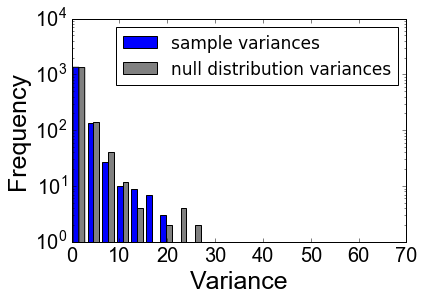

In [18]:
pylab.figure()

fig, ax = plt.subplots(1,1, figsize = (6,4))

numrandvariates = unique_plates * PLATE_ROWS * PLATE_COLS
#NUM_NULL_DIST = 1

null_var = scipy.stats.f.rvs(param2[0], param2[1], loc = param2[2], size = numrandvariates)

num_bins = 20
# the histogram of the data
newvarmax = np.amax(new_variances)
print(newvarmax)
barcolors = ['blue', 'grey']
n, bins, patches = pylab.hist([new_variances, null_var], num_bins, histtype = 'bar',
                              label = ['sample variances', 'null distribution variances'],
                             color = barcolors)

pylab.legend(fontsize = 17)
plt.xlabel('Variance', fontsize = 25, family = 'arial')
plt.ylabel('Frequency', fontsize = 25, family = 'arial')
plt.xticks(fontsize = 20, family = 'arial')
plt.yticks(fontsize = 20, family = 'arial')
plt.yscale('log', nonposy='clip')

plt.show()
fig.savefig('180612_randvarmodeling_suppfig.svg')